## Importing the data first

In [76]:
import gzip
import json
import pandas as pd

filename="goodreads_reviews_history_biography_cleaned.json.gz"

with gzip.GzipFile(filename, 'r',) as fin:
    data=[]
    for line in fin:
        info=json.loads(line.decode('utf-8'))
        new_info={}
        new_info['user_id']=info['user_id']
        new_info['book_id']=info['book_id']
        new_info['rating']=info['rating']
        new_info['date']=info['date']
        data.append(new_info)

In [77]:
data[0]

{'user_id': '8842281e1d1347389f2ab93d60773d4d',
 'book_id': '29893493',
 'rating': 5,
 'date': 'Sun Mar 12 23:33:51 -0700 2017'}

In [3]:
data[0]['date']

'Sun Mar 12 23:33:51 -0700 2017'

## Build two dictionaries that map from user_id/book_id to new integer values

user_map = {user_id to user_index}

book_map = {book_id to book_index}
 

## Exploration

Build histogram that shows how many users have between 0-5 ratings, 6-10 ratings, etc

In [9]:
import matplotlib.pyplot as plt
import numpy as np

user_to_num_ratings={}
for rating in data: 
    if rating['user_id'] not in user_to_num_ratings:
        user_to_num_ratings[rating['user_id']]=1
    else:
        user_to_num_ratings[rating['user_id']]+=1

In [39]:
counts=[]
for user in user_to_num_ratings:
    counts.append(user_to_num_ratings[user])
counts=np.array(counts)

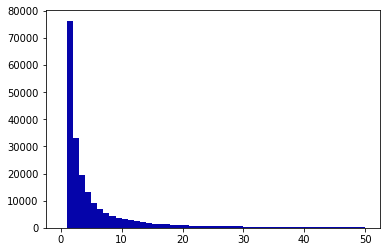

In [31]:
n, bins, patches = plt.hist(x=counts, bins=50, range=(0,50), color='#0504aa')

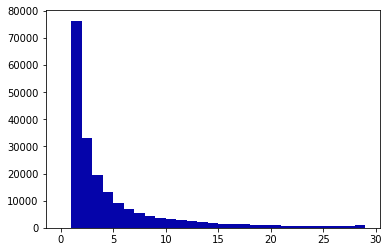

In [38]:
n, bins, patches = plt.hist(x=counts, bins=[i for i in range(0,30)], range=(0,30), color='#0504aa')

In [41]:
max(counts)

1760

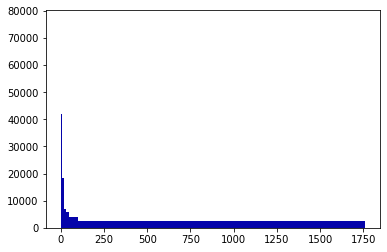

In [51]:
n, bins, patches = plt.hist(x=counts, bins=[1,2,3,6,10,20,30,50,100,1760], color='#0504aa')

In [52]:
print(n)
print(n/sum(n))

[76330. 33220. 41801. 20826. 18413.  6920.  5866.  4160.  2465.]
[0.36347446 0.15818972 0.19905143 0.09917096 0.08768053 0.03295222
 0.0279332  0.01980943 0.01173804]


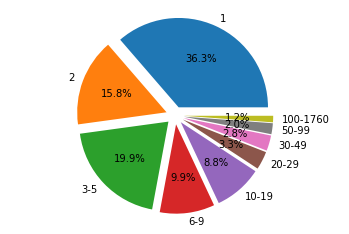

In [56]:
labels=["1","2","3-5","6-9","10-19","20-29","30-49","50-99","100-1760"]
sizes=n/sum(n)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=[0.1 for i in range(9)],labels=labels, autopct='%1.1f%%')
ax1.axis('equal') 
plt.show()


<BarContainer object of 9 artists>

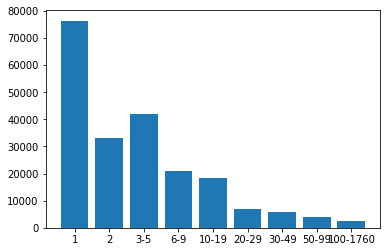

In [59]:
plt.bar(labels,n)

## Separate the training and testing sets

For users that have at least 5 ratings, testing dataset is most recent floor(0.2 x number of ratings) ratings

For users that have 2-4 ratings, use most recent rating as testing. Also include a flag that notes if user has at least 5 ratings or not.

For training, make sure format is dictionary of "book_ids": list,"user_ids": list,"ratings": list

For testing, have dictionary of category to user (like "0-5 ratings":list of lists of userid,bookid,rating, etc)

In [81]:
# Build dictionary of user -> [(date,bookid,rating),
def interpret_date_string(date_string):
    split=date_string.split(' ')
    output_str=split[-1]
    month_to_num={"Jan":"01","Feb":"02","Mar":"03","Apr":"04","May":"05","Jun":"06","Jul":"07",
                 "Aug":"08","Sep":"09","Oct":"10","Nov":"11","Dec":"12"}
    output_str=output_str+month_to_num[split[1]]+split[2]
    return int(output_str)
    
user_info={}
for rating in data:
    if rating['user_id'] not in user_info:
        user_info[rating['user_id']]=[]
    user_info[rating['user_id']].append((interpret_date_string(rating['date']),rating['book_id'],rating['rating']))
# Dictionary from user id to list of lists of date,bookid,rating

c=0
for user in user_info:
    print(user,user_info[user])
    c+=1
    if c==10:
        break

8842281e1d1347389f2ab93d60773d4d [(20170312, '29893493', 5), (20170803, '8191070', 5), (20161109, '27161156', 0), (20170104, '16064871', 5), (20160920, '19398490', 4), (20161214, '22551730', 4), (20140320, '137554', 0), (20140506, '5064', 5), (20160411, '8545079', 5), (20161221, '40955', 5), (20140111, '16008171', 5), (20120805, '9850443', 3), (20170322, '7315573', 4), (20171019, '5572634', 5), (20140104, '8296156', 3), (20170322, '8664353', 5), (20150527, '7632329', 0), (20140108, '11297044', 5), (20170322, '9418327', 4), (20170322, '9938498', 4), (20110502, '10139649', 4), (20110328, '38840', 4), (20161214, '43536', 4), (20101111, '1707053', 0), (20170322, '211099', 5), (20110922, '7518289', 5), (20100308, '3054673', 0), (20170322, '781787', 5), (20170322, '77431', 4), (20090810, '54499', 3), (20090618, '77432', 5), (20090504, '918095', 4), (20090212, '3061530', 4), (20170322, '77430', 5), (20170322, '705170', 0), (20170322, '43944', 4), (20170322, '178186', 5), (20080811, '49226', 4

In [82]:
# Categories of number of ratings: "1","2","3-5","6-9","10-19","20-29","30-49","50-99","100-1760"
training={"book_ids":[],"user_ids":[],"ratings":[]}
testing={"2":[],"3-5":[],"6-9":[],"10-19":[],"20-29":[],"30-49":[],"50-99":[],"100-1760":[]}
for user in user_info:
    l=len(user_info[user])
    user_info[user].sort()
    if l==2:
        training["book_ids"].append(user_info[user][0][1])
        training["user_ids"].append(user)
        training["ratings"].append(user_info[user][0][2])
        testing["2"].append([user,user_info[user][1][1],user_info[user][1][2]])
    elif 3<=l<=5:
        for i in range(l-1):
            training["book_ids"].append(user_info[user][i][1])
            training["user_ids"].append(user)
            training["ratings"].append(user_info[user][i][2])
        testing["3-5"].append([user,user_info[user][l-1][1],user_info[user][l-1][2]])
    elif l>5:
        cutoff=int(0.8*l)
        for i in range(cutoff):
            training["book_ids"].append(user_info[user][i][1])
            training["user_ids"].append(user)
            training["ratings"].append(user_info[user][i][2])    
        if l<=9:
            for i in range(cutoff,l):
                testing["6-9"].append([user,user_info[user][i][1],user_info[user][i][2]])
        elif l<=19:
            for i in range(cutoff,l):
                testing["10-19"].append([user,user_info[user][i][1],user_info[user][i][2]])
        elif l<=29:
            for i in range(cutoff,l):
                testing["20-29"].append([user,user_info[user][i][1],user_info[user][i][2]])
        elif l<=49:
            for i in range(cutoff,l):
                testing["30-49"].append([user,user_info[user][i][1],user_info[user][i][2]])
        elif l<=99:
            for i in range(cutoff,l):
                testing["50-99"].append([user,user_info[user][i][1],user_info[user][i][2]])
        else:
            for i in range(cutoff,l):
                testing["100-1760"].append([user,user_info[user][i][1],user_info[user][i][2]])


In [85]:
import pandas as pd
from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans

df = pd.DataFrame(training)
reader = Reader(rating_scale=(1, 5))

# Loads Pandas dataframe
data = Dataset.load_from_df(df[["user_ids", "book_ids", "ratings"]], reader)

sim_options = {"name": "cosine","user_based": True}
algo = KNNWithMeans(sim_options=sim_options)

trainingSet = data.build_full_trainset()

algo.fit(trainingSet)


Computing the cosine similarity matrix...


MemoryError: Unable to allocate 133. GiB for an array with shape (133671, 133671) and data type float64

In [ ]:
prediction = algo.predict('8842281e1d1347389f2ab93d60773d4d', '8191070')
prediction.est